In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
from fastai.imports import *

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Load the training dataset
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')

# Load the testing dataset
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

## Initial Data Exploration

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Exploratory Data Analysis
You can observe that the survival rates for females was significantly higher than males even though there are more males than females on board the Titanic.

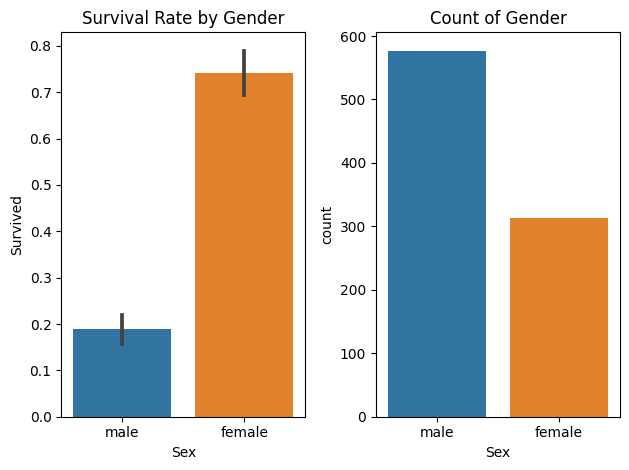

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x='Sex',y='Survived',data=train_df, ax = ax1)
ax1.set_title('Survival Rate by Gender')
sns.countplot(x='Sex', data=train_df, ax=ax2)
ax2.set_title('Count of Gender')
plt.tight_layout()
plt.show()

Analyzing the Passenger class against the survival, you can see that class 1 has the highest survival rate as it is the only class that has the most survivals out of the 3 classes. Perhaps higher class passengers had higher prioritization compared to other classes, thus having quicker access to lifeboats during the evacuation process.

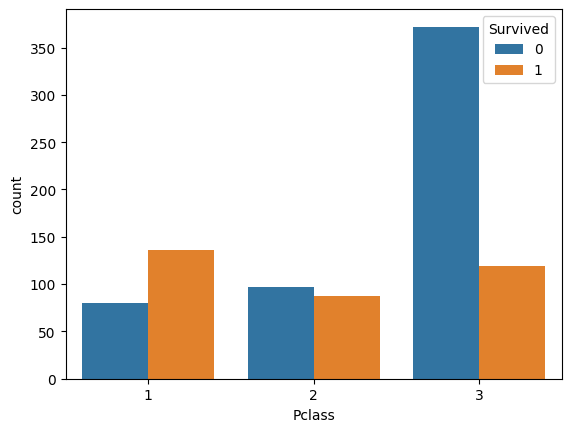

In [7]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.show()

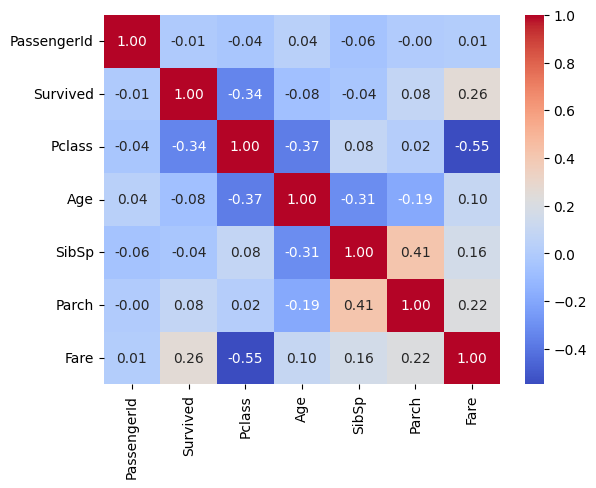

In [8]:
# Select only numeric columns for the correlation matrix
numeric_df = train_df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

## Data Cleaning
Based on the initial data exploration, there are missing values in the 'Age', 'Cabin' and 'Embarked' columns. Given the limited data, I would not want to drop any rows. For the 'Age' column, I will replace with the median value. For the 'Cabin' column, I will extract the first letter and treat it as a category on its own, for missing values I will put it under 'Unknown'. As for the 'Embarked' column, I will just replace with the mode.


In [9]:
def clean_data(df):
    # Replace missing 'Age' values with the median age
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    # Replace missing 'Fare' value with the median value
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    # Extract the first letter of the 'Cabin' and treat missing values as 'Unknown'
    df['Cabin'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'Unknown')
    
    # Replace missing 'Embarked' values with the mode
    embarked_mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(embarked_mode, inplace=True)
    
    return df

In [10]:
train_df = clean_data(train_df)

In [11]:
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [12]:
# Apply the same steps to the testing data
test_df = clean_data(test_df)

## Data Preprocessing
Here I create a function to preproces my data. <br>
For 'Sex' column, I convert it into a numerical format.<br>
For 'Fare' column, I normalized it using log to reduce skewness. <br>
Created a 'FamilySize' column that adds up 'SibSp' and 'Parch' column. <br>
Created a 'Solo' column if the passenger does not have any family members abroad the Titanic. <br>
One-hot encoded 'Embarked' and 'Cabin' column. <br>
Dropped columns not needed for model training.

In [13]:
def preprocess_data(df):
    # Convert the 'Sex' column to numerical format (female: 1, male: 0)
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)
    
    # Apply log transformation to the 'Fare' column to reduce skewness
    df['Fare_Log'] = np.log(df['Fare'] + 1)
    
    # Create 'FamilySize' feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Create 'Solo' feature
    df['Solo'] = 0
    df.loc[df['FamilySize'] == 1, 'Solo'] = 1
    
    # Encode 'Embarked' with one-hot encoding
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, embarked_dummies], axis=1)
    
    # One-hot encode 'Cabin' column
    cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')
    df = pd.concat([df, cabin_dummies], axis=1)
    
    # Drop columns that are not needed anymore and also dropped columns that are not needed for model training
    df.drop(['PassengerId','Name', 'Ticket', 'Fare', 'Embarked', 'Cabin'], axis=1, inplace=True)
    
    return df

In [14]:
train_df = preprocess_data(train_df)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    int64  
 1   Pclass         891 non-null    int64  
 2   Sex            891 non-null    int64  
 3   Age            891 non-null    float64
 4   SibSp          891 non-null    int64  
 5   Parch          891 non-null    int64  
 6   Fare_Log       891 non-null    float64
 7   FamilySize     891 non-null    int64  
 8   Solo           891 non-null    int64  
 9   Embarked_C     891 non-null    bool   
 10  Embarked_Q     891 non-null    bool   
 11  Embarked_S     891 non-null    bool   
 12  Cabin_A        891 non-null    bool   
 13  Cabin_B        891 non-null    bool   
 14  Cabin_C        891 non-null    bool   
 15  Cabin_D        891 non-null    bool   
 16  Cabin_E        891 non-null    bool   
 17  Cabin_F        891 non-null    bool   
 18  Cabin_G   

In [16]:
test_df = preprocess_data(test_df)

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Sex            418 non-null    int64  
 2   Age            418 non-null    float64
 3   SibSp          418 non-null    int64  
 4   Parch          418 non-null    int64  
 5   Fare_Log       418 non-null    float64
 6   FamilySize     418 non-null    int64  
 7   Solo           418 non-null    int64  
 8   Embarked_C     418 non-null    bool   
 9   Embarked_Q     418 non-null    bool   
 10  Embarked_S     418 non-null    bool   
 11  Cabin_A        418 non-null    bool   
 12  Cabin_B        418 non-null    bool   
 13  Cabin_C        418 non-null    bool   
 14  Cabin_D        418 non-null    bool   
 15  Cabin_E        418 non-null    bool   
 16  Cabin_F        418 non-null    bool   
 17  Cabin_G        418 non-null    bool   
 18  Cabin_Unkn

In [18]:
# List of all possible categories for the 'Cabin' feature from the training set
cabin_categories = ['Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_Unknown']

for category in cabin_categories:
    if category not in test_df.columns:
        test_df[category] = 0

In [19]:
# Define the new order of the columns where Cabin_Unknown is to come after Cabin_T
column_order = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare_Log',
                'FamilySize', 'Solo', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_A',
                'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
                'Cabin_Unknown']

test_df = test_df[column_order]

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         418 non-null    int64  
 1   Sex            418 non-null    int64  
 2   Age            418 non-null    float64
 3   SibSp          418 non-null    int64  
 4   Parch          418 non-null    int64  
 5   Fare_Log       418 non-null    float64
 6   FamilySize     418 non-null    int64  
 7   Solo           418 non-null    int64  
 8   Embarked_C     418 non-null    bool   
 9   Embarked_Q     418 non-null    bool   
 10  Embarked_S     418 non-null    bool   
 11  Cabin_A        418 non-null    bool   
 12  Cabin_B        418 non-null    bool   
 13  Cabin_C        418 non-null    bool   
 14  Cabin_D        418 non-null    bool   
 15  Cabin_E        418 non-null    bool   
 16  Cabin_F        418 non-null    bool   
 17  Cabin_G        418 non-null    bool   
 18  Cabin_T   

## Building a Random Forest Model

In [21]:
# separate features and target
X = train_df.drop('Survived', axis=1) 
y = train_df['Survived']              

In [22]:
from sklearn.model_selection import train_test_split

# Split the data - 80% for training and 20% for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

## Evaluate Random Forest Model performance

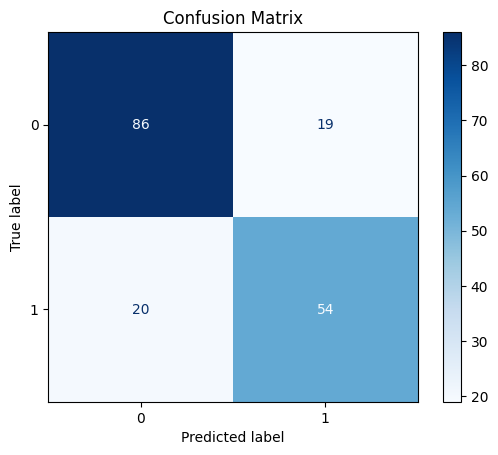

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Generate predictions on the validation set
y_pred = rf.predict(X_valid)

# Generate the confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [25]:
class_report = classification_report(y_valid, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       105
           1       0.74      0.73      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



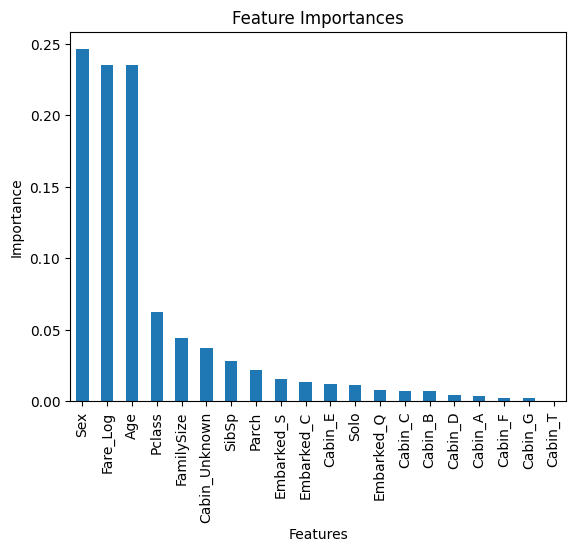

In [26]:
# Retrieve feature importances from the model
feature_importances = rf.feature_importances_

importances = pd.Series(feature_importances, index=X_train.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Plot the feature importances
sorted_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## Fine-tune Random Forest Model using GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion':['gini','entropy'],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [True, False]
}

In [28]:
rf_ft = RandomForestClassifier(random_state=42)

# Initialize  GridSearchCV 
grid_search = GridSearchCV(estimator=rf_ft, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [29]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=2, min_samples_split=3, n_estimators=150; total time=   0.6s
[CV] 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 150, 200]},
             verbose=2)

In [30]:
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [31]:
# Train the best model
best_rf = grid_search.best_estimator_

# Evaluate on the test data
best_rf_accuracy = best_rf.score(X_valid, y_valid)
print(f"Test accuracy of the best model: {best_rf_accuracy}")

Test accuracy of the best model: 0.8100558659217877


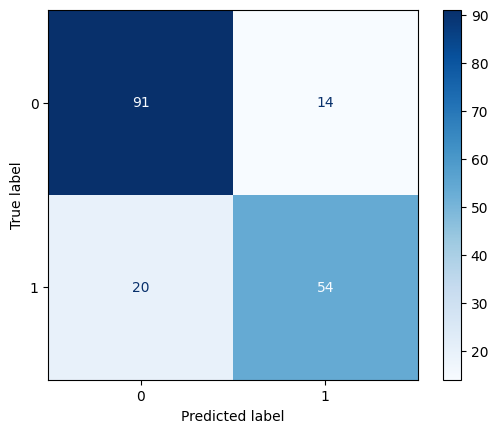

In [32]:
# Use the best model to make predictions on the validation set
y_pred = best_rf.predict(X_valid)

# Generate the confusion matrix display
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, cmap='Blues')
plt.show()

In [33]:
class_report = classification_report(y_valid, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Submit on test dataset

In [34]:
test_pred = best_rf.predict(test_df)

In [35]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_rf = test_df[['PassengerId']].copy()
submission_rf['Survived'] = test_pred

In [36]:
submission_rf.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
